In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import glob
import gdown
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import csv
import cv2
import itertools
import matplotlib.pyplot as plt
import skimage.feature as feature
import xlwings as xw
import torchvision.transforms as transforms

import random

#libraries for yolo
from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression
from pytorchyolo.utils.loss import compute_loss

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator, FuncFormatter, )

In [2]:
device, model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [3]:
class LocalBinaryPatterns:
  def __init__(self, numPoints, radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self, image, eps = 1e-7):
    lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints+3), range=(0, self.numPoints + 2))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp

# From https://medium.com/mlearning-ai/how-to-plot-color-channels-histogram-of-an-image-in-python-using-opencv-40022032e127
# Extracts image's color channel
def extract_color_channel(path, face_index, image, version):
    # BGR Image Color Conversion
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    r, g, b = cv2.split(rgb)
    
    r *= 255
    g *= 255
    b *= 255
    
    r_hist = cv2.calcHist(r, [0], None, [26], [0, 256])
    r_hist = r_hist.ravel()
    r_hist = r_hist.astype('float')
    r_hist /= r_hist.sum()
    
    g_hist = cv2.calcHist([g], [0], None, [26], [0, 256])
    g_hist = g_hist.ravel()
    g_hist = g_hist.astype('float')
    g_hist /= g_hist.sum()
    
    b_hist = cv2.calcHist([b], [0], None, [26], [0, 256])
    b_hist = b_hist.ravel()
    b_hist = b_hist.astype('float')
    b_hist /= b_hist.sum()
    
    h, s, v = cv2.split(hsv)
    
    s *= 255
    v *= 255
    
    h_hist_HSV = cv2.calcHist([h], [0], None, [36], [0, 361])
    h_hist_HSV = h_hist_HSV.ravel()
    h_hist_HSV = h_hist_HSV.astype('float')
    h_hist_HSV /= h_hist_HSV.sum()
    
    s_hist_HSV = cv2.calcHist([s], [0], None, [26], [0, 256])
    s_hist_HSV = s_hist_HSV.ravel()
    s_hist_HSV = s_hist_HSV.astype('float')
    s_hist_HSV /= s_hist_HSV.sum()
    
    v_hist_HSV = cv2.calcHist([v], [0], None, [26], [0, 256])
    v_hist_HSV = v_hist_HSV.ravel()
    v_hist_HSV = v_hist_HSV.astype('float')
    v_hist_HSV /= v_hist_HSV.sum()
    
    h, l, s = cv2.split(hls)
    
    l *= 255
    s *= 255
    
    h_hist_HSL = cv2.calcHist([h], [0], None, [36], [0, 361])
    h_hist_HSL = h_hist_HSL.ravel()
    h_hist_HSL = h_hist_HSL.astype('float')
    h_hist_HSL /= h_hist_HSL.sum()
    
    l_hist_HSL = cv2.calcHist([l], [0], None, [26], [0, 256])
    l_hist_HSL = l_hist_HSL.ravel()
    l_hist_HSL = l_hist_HSL.astype('float')
    l_hist_HSL /= l_hist_HSL.sum()
    
    s_hist_HSL = cv2.calcHist([s], [0], None, [26], [0, 256])
    s_hist_HSL = s_hist_HSL.ravel()
    s_hist_HSL = s_hist_HSL.astype('float')
    s_hist_HSL /= s_hist_HSL.sum()
    
    l, a, b = cv2.split(lab)
    
    l_hist_LAB = cv2.calcHist([l], [0], None, [26], [0, 256])
    l_hist_LAB = l_hist_LAB.ravel()
    l_hist_LAB = l_hist_LAB.astype('float')
    l_hist_LAB /= l_hist_LAB.sum()
    
    a_hist_LAB = cv2.calcHist([a], [0], None, [26], [0, 256])
    a_hist_LAB = a_hist_LAB.ravel()
    a_hist_LAB = a_hist_LAB.astype('float')
    a_hist_LAB /= a_hist_LAB.sum()
    
    b_hist_LAB = cv2.calcHist([b], [0], None, [26], [0, 256])
    b_hist_LAB = b_hist_LAB.ravel()
    b_hist_LAB = b_hist_LAB.astype('float')
    b_hist_LAB /= b_hist_LAB.sum()
    
    
    y, cr, cb = cv2.split(ycrcb)
    
    y *= 255
    cr *= 255
    cb *= 255
    
    y_hist = cv2.calcHist([y], [0], None, [26], [0, 256])
    y_hist = y_hist.ravel()
    y_hist = y_hist.astype('float')
    y_hist /= y_hist.sum()
    
    cr_hist = cv2.calcHist([cr], [0], None, [26], [0, 256])
    cr_hist = cr_hist.ravel()
    cr_hist = cr_hist.astype('float')
    cr_hist /= cr_hist.sum()
    
    cb_hist = cv2.calcHist([cb], [0], None, [26], [0, 256])
    cb_hist = cb_hist.ravel()
    cb_hist = cb_hist.astype('float')
    cb_hist /= cb_hist.sum()
    
    face_index = str(face_index)
    
    return r_hist, g_hist, b_hist, h_hist_HSV, s_hist_HSV, v_hist_HSV, h_hist_HSL, s_hist_HSL, l_hist_HSL, l_hist_LAB, a_hist_LAB, b_hist_LAB, y_hist, cr_hist, cb_hist

# From https://medium.com/mlearning-ai/color-shape-and-texture-feature-extraction-using-opencv-cb1feb2dbd73
# Extracts Local Binary Pattern (Texture) of an image
def extract_lbp(path, face_index, image, version):
    # reads the input image as a grayscale image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    desc = LocalBinaryPatterns(24, 8)
    lbp_hist, lbp_img = desc.describe(gray)
    
    return lbp_hist
    
# From https://docs.opencv.org/4.x/d2/d2c/tutorial_sobel_derivatives.html and https://gist.github.com/rahit/c078cabc0a48f2570028bff397a9e154
def extract_gradients(path, face_index, image, version):
    # Uses the Sobel Filter to extract the gradients of an image
    # reads the input image, then converts BGR color space to RGB
    # img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # compute the 1st order Sobel derivative in X-direction
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)

    # compute the 1st order Sobel derivative in Y-direction
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    
    # combine sobelx and sobely to form sobel
    sobel = sobelx + sobely
    
    sobelx_hist = cv2.calcHist([np.float32(sobelx)], [0], None, [26], [0, 256])
    sobelx_hist = sobelx_hist.ravel()
    sobelx_hist = sobelx_hist.astype('float')
    sobelx_hist /= sobelx_hist.sum()
    
    sobely_hist = cv2.calcHist([np.float32(sobely)], [0], None, [26], [0, 256])
    sobely_hist = sobely_hist.ravel()
    sobely_hist = sobely_hist.astype('float')
    sobely_hist /= sobely_hist.sum()
    
    sobel_hist = cv2.calcHist([np.float32(sobel)], [0], None, [26], [0, 256])
    sobel_hist = sobel_hist.ravel()
    sobel_hist = sobel_hist.astype('float')
    sobel_hist /= sobel_hist.sum()
    
    return sobelx_hist, sobely_hist, sobel_hist

def extract_image_attributes(row, path, face_index, image, version):
    r_hist, g_hist, b_hist, h_hist_HSV, s_hist_HSV, v_hist_HSV, h_hist_HSL, s_hist_HSL, l_hist_HSL, l_hist_LAB, a_hist_LAB, b_hist_LAB, y_hist, cr_hist, cb_hist = extract_color_channel(path, face_index, image, version)
    lbp_hist = extract_lbp(path, face_index, image, version)
    sobelx_hist, sobely_hist, sobel_hist = extract_gradients(path, face_index, image, version)
    
    RGB_size = SV_HSV_size = SL_HSL_size = LAB_size = YCRCB_size = 26
    
    for i in range(0, RGB_size):
        row['R_BIN_' + version + '_' + str(i)] = r_hist[i]
        
    for i in range(0, RGB_size):
        row['G_BIN_' + version + '_' + str(i)] = g_hist[i]
        
    for i in range(0, RGB_size):
        row['B_BIN_' + version + '_' + str(i)] = b_hist[i]
        
    for i in range(0, h_hist_HSV.size):
        row['H_HSV_BIN_' + version + '_' + str(i)] = h_hist_HSV[i]
        
    for i in range(0, SV_HSV_size):
        row['S_HSV_BIN_' + version + '_' + str(i)] = s_hist_HSV[i]
        
    for i in range(0, SV_HSV_size):
        row['V_HSV_BIN_' + version + '_' + str(i)] = v_hist_HSV[i]
        
    for i in range(0, h_hist_HSL.size):
        row['H_HSL_BIN_' + version + '_' + str(i)] = h_hist_HSL[i]
        
    for i in range(0, SL_HSL_size):
        row['S_HSL_BIN_' + version + '_' + str(i)] = s_hist_HSL[i]
        
    for i in range(0, SL_HSL_size):
        row['L_HSL_BIN_' + version + '_' + str(i)] = l_hist_HSL[i]
        
    for i in range(0, LAB_size):
        row['L_LAB_BIN_' + version + '_' + str(i)] = l_hist_LAB[i]
    
    for i in range(0, LAB_size):
        row['A_LAB_BIN_' + version + '_' + str(i)] = a_hist_LAB[i]
        
    for i in range(0, LAB_size):
        row['B_LAB_BIN_' + version + '_' + str(i)] = b_hist_LAB[i]
        
    for i in range(0, YCRCB_size):
        row['Y_BIN_' + version + '_' + str(i)] = y_hist[i]
        
    for i in range(0, YCRCB_size):
        row['CR_BIN_' + version + '_' + str(i)] = cr_hist[i]
        
    for i in range(0, YCRCB_size):
        row['CB_BIN_' + version + '_' + str(i)] = cb_hist[i]
        
    for i in range(0, lbp_hist.size):
        row["LBP_BIN_" + version + '_' + str(i)] = lbp_hist[i]
        
    for i in range(0, sobelx_hist.size):
        row["SOBELX_BIN_" + version + '_' + str(i)] = sobelx_hist[i]
        
    for i in range(0, sobely_hist.size):
        row["SOBELY_BIN_" + version + '_' + str(i)] = sobely_hist[i]
        
    for i in range(0, sobel_hist.size):
        row["SOBEL_BIN_" + version + '_' + str(i)] = sobel_hist[i]
    
    return row

In [4]:
def detach_cpu(image):
    return image.detach().cpu()

# convert 1x3x416x416 to 416x416x3
def reshape_image(image):
    return np.transpose(np.squeeze(image), (1 ,2, 0))

# convert 1x3x416x416 tensor to 416x416x3 numpy image
def tensor_to_image(image):
    return np.transpose(image.detach().cpu().squeeze().numpy(), (1, 2, 0))

def save_tensor_as_image(image, path):
    save_img = cv2.cvtColor(np.moveaxis((image.detach().numpy() * 255).squeeze(), 0, -1).astype('uint8'), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, save_img)

In [42]:
def fgsm_attack(image, e, data_grad, bbox):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign().numpy()
    # Create the perturbed image by adjusting each pixel of the input image
    image = image.clone().detach()
    perturbed_image = image
    x1, y1, x2, y2 = bbox
    perturbed_image[..., y1:y2, x1:x2] = perturbed_image[..., y1:y2, x1:x2] + e * sign_data_grad[..., y1:y2, x1:x2]
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [35]:
def pipeline(model, device, path, eps_model):
    
    torch.autograd.set_detect_anomaly(True)
    row = {} #the information/columns for a single row in the dataset is stored here
    
    df = pd.DataFrame() # dataframe storing the dataset
    row['path'] = path
    file_basename = os.path.basename(path)
    
    model.eval()

    model.gradient_mode = False
    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = False

    # read and transform the image from the path
    data = cv2.imread(path)  # read the image
    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
    data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image

    with torch.no_grad():
        # Forward pass the data through the model and call non max suppression
        nms, nms_output = non_max_suppression(model(data), 0.5, 0.5) #conf_thres and iou_thres = 0.5

    face_list = []
    if type(nms_output[0]) is not int:
        face_list = nms_output[0]

    data = data.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    model.gradient_mode = True
    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = True

    output = model(data)

    # loop through each of the faces in the image
    for face_index, face_row in enumerate(face_list): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time

        row['face_index'] = face_index
        print("Face", face_index)

        x, y, w, h = face_row[0], face_row[1], face_row[2], face_row[3]
        row['x'], row['y'], row['w'], row['h'] = x, y, w, h
        
        factor_x, factor_y, factor_w, factor_h = random.uniform(1, 2), random.uniform(1, 2), random.uniform(1, 2), random.uniform(1, 2)
        normal_x, normal_y, normal_w, normal_h = x / 416, y / 416, w / 416, h / 416

        new_x = normal_x * factor_x if random.choice([True, False]) else normal_x / factor_x
        new_y = normal_y * factor_y if random.choice([True, False]) else normal_y / factor_y
        new_w = normal_w * factor_w if random.choice([True, False]) else normal_w / factor_w
        new_h = normal_h * factor_h if random.choice([True, False]) else normal_h / factor_h

        new_x, new_y, new_w, new_h = max(min(1, new_x), 0), max(min(1, new_y), 0), max(min(1, new_w), 0), max(min(1, new_h), 0)

        target = torch.tensor([[0.0, 0, new_x, new_y, new_w, new_h]])
        target = target.to(device)

        loss, loss_components = compute_loss(output, target, model)

        # cropped image with bounding box
        # getting (x1, y1) upper left, (x2, y2) lower right
        x1 = max(int(np.floor((x - w / 2).detach().cpu().numpy())), 0)
        y1 = max(int(np.floor((y - h / 2).detach().cpu().numpy())), 0)
        x2 = min(int(np.ceil((x + w / 2).detach().cpu().numpy())), 415)
        y2 = min(int(np.ceil((y + h / 2).detach().cpu().numpy())), 415)

        cropped_image = detach_cpu(data)[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
        cropped_image = tensor_to_image(cropped_image) #reshape the image to (w/h, h/w, channel)

        # Zero all existing gradients
        model.zero_grad()
        data.grad = None

        # Calculate gradients of model in backward pass
        loss.backward(retain_graph=True) #TODO: Amos - check if this is correct

        # Collect datagrad
        data_grad = data.grad.data

        row = extract_image_attributes(row, path, face_index, cropped_image, "bbox")
        
        
        row['x'], row['y'], row['w'], row['h'] = row['x'] / 416, row['y'] / 416, row['w'] / 416, row['h'] / 416
        
        
        df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe
        
        predict_features = get_features(CHOSEN_COLOR_SPACE, CHOSEN_REGION)
        X_features = df.loc[:,  predict_features]
        
        min_eps = eps_model.predict(X_features)
        
        return fgsm_attack(data, min_eps, data_grad, (x1, y1, x2, y2))

In [26]:
def get_features(color_space, region):
    features = ["w", "h", "x", "y"]
    for color_channel in color_channels[color_space]: 
        features += [color_channel + region + "_" + str(i) for i in range(26)]
    features += ["LBP_BIN_" + region + "_" + str(i) for i in range(26)]
    features += ["SOBELX_BIN_" + region + "_" + str(i) for i in range(20)]
    features += ["SOBELY_BIN_" + region + "_" + str(i) for i in range(20)]
    features += ["SOBEL_BIN_" + region + "_" + str(i) for i in range(20)]
    return features

In [21]:
feat_regions = ["bbox", "mask"]

color_channels = {
    "RGB": ("R_BIN_", "G_BIN_", "B_BIN_"),
    "HSV": ("H_HSV_BIN_", "S_HSV_BIN_", "V_HSV_BIN_"),
    "HSL": ("H_HSL_BIN_", "S_HSL_BIN_", "L_HSL_BIN_"),
    "LAB": ("L_LAB_BIN_", "A_LAB_BIN_", "B_LAB_BIN_"),
    "YCBCR": ("Y_BIN_", "CR_BIN_", "CB_BIN_"),
}

In [22]:
img_path = "E:\\Documents\\GitHub\\THS-ST1\\images\\img_celeba_139\\139005.jpg"
CHOSEN_COLOR_SPACE = "LAB" #<-- pick a colorspace
CHOSEN_REGION = "bbox"

In [23]:
#TODO: load model here (edit this whole cell as necessary, idk paano magproperly load from joblib)
random_state = 100

import joblib
from sklearn.base import clone as clone_model

CSV_FILENAME = "final_eda_features.csv" #<-- update csv name
df_features = pd.read_csv(CSV_FILENAME)

labels = {"mask": "e_bbox_yf", "bbox": "e_face_yf"} #<-- inverted

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
categorical_columns = df_features.select_dtypes(include=[bool, object]).columns
encoded_columns = df_features[categorical_columns].apply(encoder.fit_transform)

df_encoded_features = df_features.copy()
df_encoded_features[categorical_columns] = encoded_columns

def get_features_and_label(color_space, region):
    features = ["w", "h", "x", "y"]
    for color_channel in color_channels[color_space]: 
        features += [color_channel + region + "_" + str(i) for i in range(26)]
    features += ["LBP_BIN_" + region + "_" + str(i) for i in range(26)]
    features += ["SOBELX_BIN_" + region + "_" + str(i) for i in range(20)]
    features += ["SOBELY_BIN_" + region + "_" + str(i) for i in range(20)]
    features += ["SOBEL_BIN_" + region + "_" + str(i) for i in range(20)]
    return features, labels[region]

from sklearn.model_selection import train_test_split
features, label = get_features_and_label(CHOSEN_COLOR_SPACE, CHOSEN_REGION)

X_features =  df_encoded_features.loc[:,  features]
y_features = df_encoded_features.loc[:, label].values #<-- pick label

X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size = 0.2, random_state=random_state)

eps_model = joblib.load("model_dumps/mpr_tunedfs_LAB_bbox.pkl")
eps_model.fit(X_train, y_train)

E:\Program Files\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Pipeline(steps=[('selector',
                 SelectKBest(k=109,
                             score_func=<function f_regression at 0x00000294D9BB5820>)),
                ('mpr',
                 MLPRegressor(alpha=0.0006027865352538995,
                              beta_1=0.798511248023137, beta_2=0.85,
                              early_stopping=True, epsilon=1e-07,
                              hidden_layer_sizes=(113, 75, 50),
                              learning_rate_init=0.005, max_fun=11112,
                              max_iter=1000, momentum=0.8014392629174594,
                              n_iter_no_change=15, nesterovs_momentum=False,
                              random_state=100, tol=0.1,
                              validation_fraction=0.14942278940909776))])

Face 0


C:\Users\Janjan Chua\AppData\Local\Temp\ipykernel_7228\3713452722.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


TypeError: Invalid shape (1, 3, 416, 416) for image data

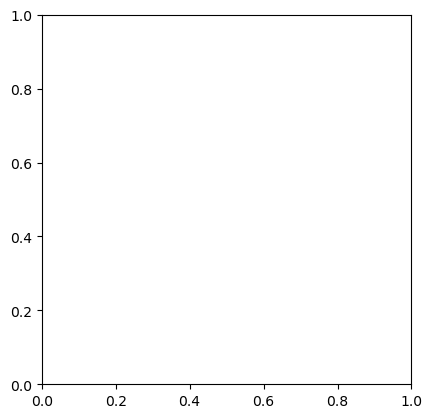

In [43]:
image = pipeline(model, device, img_path, eps_model)
plt.imshow(image)

In [44]:
type(image)

torch.Tensor